
<div style="text-align: center;">
    <h1>ReConPatch: anomaly detection</h1>
    <h3>Authors:</h3>
    <p>Dario Loi 1940849, Elena Muia 1938610, Martina Doku 1938629</p>

</div>


<div>
    <h2>0 - Introduction</h2>
    <p>This project aims to reimplement and potentially advance the ReConPatch method proposed in the paper titled  <a href="https://arxiv.org/pdf/2305.16713v3">”ReConPatch:
Anomaly Detection by Linear Modulation of Pretrained Features.”</a> This method addresses the challenge of
anomaly detection by constructing discriminative features through a linear modulation of patch features extracted
from pre-trained models and employs contrastive representation learning to collect and distribute features in a way
that produces a target-oriented and easily separable representation of the data.</p>
</div>


In [1]:
pip install ema-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 16.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5983 sha256=182d105ff61763733a7e5279efea2f749d188b4be6675326868dd04c8e5a21e4
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from typing import Optional
from lightning import LightningDataModule, LightningModule
import lightning.pytorch as pl
import torch.optim as optim
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from ema_pytorch import EMA
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.optim.lr_scheduler import CosineAnnealingLR
from adamp import AdamP
from torchvision.transforms import transforms
from sklearn import random_projection
import numpy as np
import matplotlib.pyplot as plt
import random

<div>
    <h2>1.1 - Data</h2>
    <p>In this study, we used the <a href="https://arxiv.org/pdf/2305.16713v3">MVTec AD</a> dataset
and <a href="https://arxiv.org/pdf/2305.16713v3">BTAD</a> dataset for our experiments</p>
</div>


In [5]:
#data
#downloaded from https://www.kaggle.com/uciml/pima-indians-diabetes-database
#!wget https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads/mvtec_anomaly_detection.tar.xz


In [6]:
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MVTecADDataset(Dataset):
    def __init__(self, root_dir, phase, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.phase = phase
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.data = []
        self.masks = {}
        
        if self.phase == 'train':
            self._load_train_data()
        else:
            self._load_test_data()
        
    def _load_train_data(self):
        for subclass in ["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]:
            train_dir = os.path.join(self.root_dir,subclass, 'train', 'good')
            image_paths = glob.glob(os.path.join(train_dir, '*.png'))

            for image_path in image_paths:
                self.data.append((image_path, 0))
    
    def _load_test_data(self):
        for subclass in ["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]:
                test_dir = os.path.join(self.root_dir,subclass, 'test')
                mask_dir = os.path.join(self.root_dir,subclass, 'ground_truth')
                categories = os.listdir(test_dir)

                for category in categories:
                    category_dir = os.path.join(test_dir, category)
                    if category == 'good':
                        image_paths = glob.glob(os.path.join(category_dir, '*.png'))
                        for image_path in image_paths:
                            self.data.append((image_path, 0))
                    else:
                        image_paths = glob.glob(os.path.join(category_dir, '*.png'))
                        for image_path in image_paths:
                            self.data.append((image_path, 1))
                            mask_path = os.path.join(mask_dir, category, os.path.basename(image_path).replace('.png', '_mask.png'))
                            self.masks[image_path] = mask_path

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.image_transform:
            image = self.image_transform(image)
        
        if label == 1 and self.phase == 'test':
            mask_path = self.masks[image_path]
            mask = Image.open(mask_path).convert("L")
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, label, mask
        
        return image, label



class MVTecDataModule(LightningDataModule):
    def __init__(self, root_dir, batch_size=32, image_transform=None, mask_transform=None, custom_collate_fn=None):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_transform = image_transform
        self.mask_transform=mask_transform
    
    def setup(self, stage=None):
        full_train_dataset = MVTecADDataset(self.root_dir, phase='train', image_transform=self.image_transform, mask_transform=self.mask_transform)
        
        # Split the dataset
        train_size = int(0.8 * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])
        
        self.test_dataset = MVTecADDataset(self.root_dir, phase='test', image_transform=self.image_transform, mask_transform=self.mask_transform)

    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,collate_fn=custom_collate_fn, num_workers = 4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers = 4)

    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers = 4)
    def show_examples(self, dataloader, title):
        
        # Get a batch of samples
        images, labels = next(iter(dataloader))
        # Select one sample from the batch
        image = images[0]
        # Convert the tensor to a numpy array for displaying
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f'{title}')
        plt.show()

    def show_random_images(self, dataloader, title, num_images=10):
        fig, axs = plt.subplots(2, num_images, figsize=(20, 8))
        axs = axs.flatten()

        # Randomly select images from the dataloader
        selected_indices = random.sample(range(len(dataloader.dataset)), num_images)
        
        for i, idx in enumerate(selected_indices):
            sample = dataloader.dataset[idx]
            if isinstance(sample, tuple) and len(sample) == 3:
                image, label, mask = sample
            else:
                image, label = sample
                mask = None
            
            # Ensure the image is a tensor
            if isinstance(image, Image.Image):
                image = transforms.ToTensor()(image)
            if mask is not None and isinstance(mask, Image.Image):
                mask = transforms.ToTensor()(mask)
            
            image = image.permute(1, 2, 0).numpy()
            axs[2*i].imshow(image)
            axs[2*i].set_title(f'{title} - Label: {label}')
            axs[2*i].axis('off')

            if mask is not None and len(mask) > 0:
                mask = mask.permute(1, 2, 0).numpy()
                axs[2*i + 1].imshow(mask, cmap='gray')
                axs[2*i + 1].set_title(f'{title} - Mask')
                axs[2*i + 1].axis('off')
            else:
                axs[2*i + 1].axis('off')

        plt.tight_layout()
        plt.show()



In [7]:
def custom_collate_fn(batch):
    images = []
    labels = []
    masks = []

    for item in batch:
        images.append(item[0])
        labels.append(item[1])
        if len(item) == 3:
            masks.append(item[2])
    
    images = torch.stack(images)
    labels = torch.tensor(labels)
    
    if masks:
        masks = torch.stack(masks)
        return images, labels, masks
    return images, labels
# Define transforms to ensure consistent image sizes
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to the same size
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all masks to the same size
    transforms.ToTensor(),
])


In [8]:
data_module = MVTecDataModule(root_dir='/kaggle/input/mvtec-ad',batch_size=8, custom_collate_fn=custom_collate_fn,image_transform=image_transform, mask_transform=mask_transform)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

In [9]:
'''
for sample in tqdm(test_loader):
    if len(sample) == 3:
        img, label, mask = sample
        print(f"Image shape: {img.shape}, Label: {label.shape}, Mask shape: {mask.shape}")
    else:
        img, label = sample
        print(f"Image shape: {img.shape}, Label: {label.shape}")
'''

'\nfor sample in tqdm(test_loader):\n    if len(sample) == 3:\n        img, label, mask = sample\n        print(f"Image shape: {img.shape}, Label: {label.shape}, Mask shape: {mask.shape}")\n    else:\n        img, label = sample\n        print(f"Image shape: {img.shape}, Label: {label.shape}")\n'

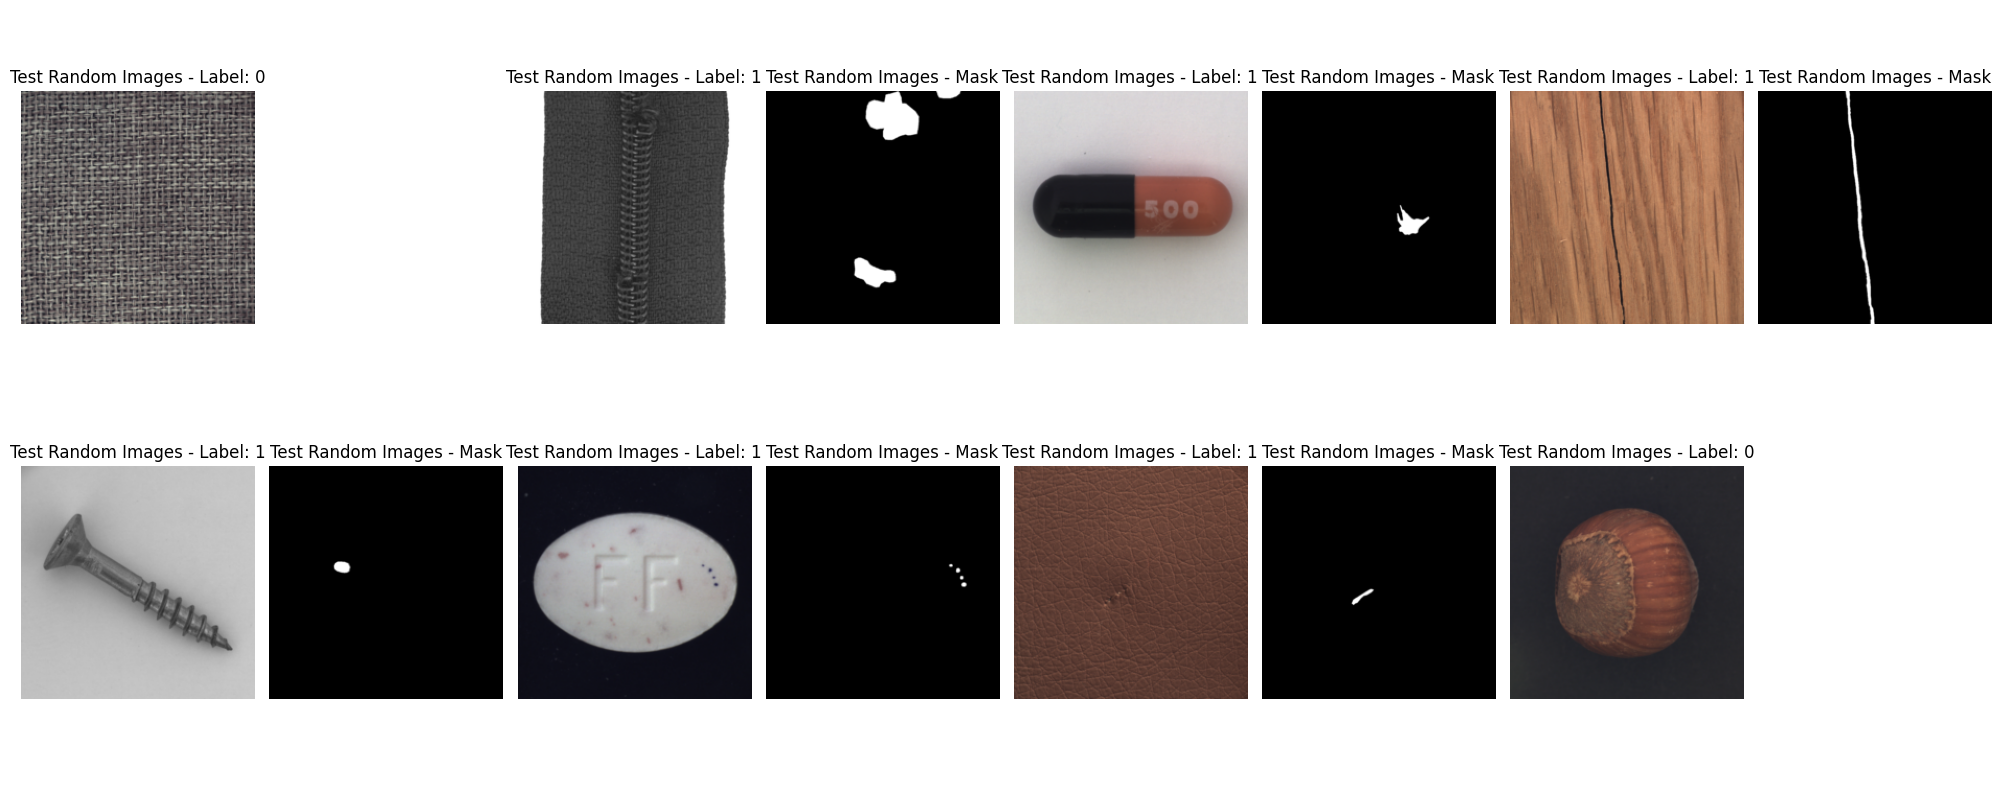

In [10]:
data_module.show_random_images(test_loader, 'Test Random Images', num_images=8)

In [11]:
#Algorithm defined in PatchCore paper
def obtainCoreset(
        memory_bank,
        l = 1000, 
        eps = 0.5,
        ):
    
    #random linear projection in lower dimension (more details in citation 49)
    memory_bank = memory_bank.detach().cpu().numpy()
    transformer = random_projection.SparseRandomProjection(eps=eps)
    memory_bank = torch.tensor(transformer.fit_transform(memory_bank))
    last_val = memory_bank[0]
    coreset_indices = [0]
    min_distances = torch.linalg.norm(memory_bank - last_val, dim= 1, keepdims = True)

    for _ in tqdm(range(l - 1)):
        distances = torch.linalg.norm(memory_bank - last_val, dim = 1, keepdims = True)
        min_distances = torch.minimum(distances, min_distances)
        index = torch.argmax(min_distances).item()       
        last_val = memory_bank[index]
        min_distances[index] = 0
        coreset_indices.append(index)
    return torch.tensor(coreset_indices)
    

In [12]:
def relaxedContrastiveLoss(w, delta, m): 
    return torch.mean(w * delta**2 + (1 - w) * torch.max(m - delta, torch.tensor(0.0))**2)


In [13]:
#We set \sigma = 1 based on the cited papers 18 and 19 in ReConPatch
class ContextualSimilarity(nn.Module):
    def __init__(self, k = 5, alpha = 0.5):
        super(ContextualSimilarity, self).__init__()
        self.k = k
        self.alpha = alpha
        
    def forward(self, z):
        distances = torch.cdist(z,z)  
        topk_dist = -torch.topk(-distances, self.k)[0][:,-1]
        filtering = (distances <= topk_dist.unsqueeze(-1)).float()
        similarity = torch.matmul(filtering, filtering.transpose(0, 1)) / torch.sum(filtering, dim=-1, keepdim=True)
        R = filtering * filtering.transpose(0, 1)
        similarity = torch.matmul(similarity, R.transpose(0, 1)) / torch.sum(R, dim=-1, keepdim=True)
        return self.alpha * (similarity + similarity.transpose(0, 1))
        
        
class PairwiseSimilarity(nn.Module):
    def __init__(self, sigma = 1.0):
        super(PairwiseSimilarity, self).__init__()
        self.sigma = sigma
    def forward(self,z):
        return torch.exp(-(torch.cdist(z,z)/self.sigma))


class ReConPatch(LightningModule):
    def __init__(
        self,
        input_dim = 1536,
        emb_dim = 512,
        proj_dim = 1024,
        alpha = 0.5,
        margin=0.1,
        
    ):  
        super(ReConPatch, self).__init__() 
        self.memory_bank = []
        self.memory_bank_sample = []
        
        self.fmap =[]
        
        #self.auroc = AUROC(task="multiclass", num_classes=15)
        self.margin = margin
        self.alpha = alpha

        self.frac_rate= 0.01
        self.eps_coreset = 0.5
        self.wr_model = torch.hub.load('pytorch/vision:v0.13.0', 'wide_resnet50_2', pretrained=True)
        
        def hook(module, input, output):
            self.fmap.append(output)
        self.wr_model.layer2.register_forward_hook(hook)            
        self.wr_model.layer3.register_forward_hook(hook)
        #setup network 1
        self.repr_layer = nn.Linear(input_dim, emb_dim)
        self.proj_layer = nn.Linear(emb_dim, proj_dim)
        
        #setup network 2
        self.repr_layer_2=nn.Linear(input_dim, emb_dim)
        self.proj_layer_2=nn.Linear(emb_dim, proj_dim)
        self.ema_repr = EMA(self.repr_layer_2)
        self.ema_proj = EMA(self.proj_layer_2) 
        #???
        with torch.no_grad():
            self.proj_layer.weight.copy_(torch.randn_like(self.proj_layer.weight))
            self.proj_layer.bias.copy_(torch.randn_like(self.proj_layer.bias))
            self.repr_layer.weight.copy_(torch.randn_like(self.repr_layer.weight))
            self.repr_layer.bias.copy_(torch.randn_like(self.repr_layer.bias))
        self.ema_repr.update()
        self.ema_proj.update()
        
        self.pairwise_sim=PairwiseSimilarity()
        self.contextual_sim=ContextualSimilarity()
    def forward(self, x):
        '''
        x has dimensions B x C x H x W (batch channels height width)
        '''
        #-----------FROM PRETRAINED MODEL TO FEATURE MAP
        self.fmap = []
        self.memory_bank_sample = []
        
        y = self.wr_model(x)
        
        #NOTE: We are taking as dimensions the ones of the feature map with higher resolution as specified in
        #chapter 3.1 of the patchcore paper (https://arxiv.org/pdf/2106.08265)
        dimensions = (
                int(torch.Tensor([t.shape[-2] for t in self.fmap]).max().item()),
                int(torch.Tensor([t.shape[-1] for t in self.fmap]).max().item())
            )
        
        blur = nn.AvgPool2d(3, stride = 1)
        resizer = nn.AdaptiveAvgPool2d(dimensions)
        preprocess = lambda t : resizer(blur(t))
        feature_stacks = torch.cat([preprocess(m) for m in self.fmap], dim=1)
        
        
        #-----------RECONPATCH
        feature_stacks_reshaped = feature_stacks.reshape(feature_stacks.shape[1], -1).T
        #feature_stacks_reshaped_cpu = feature_stacks_reshaped.detach().cpu().numpy()
        self.memory_bank_sample.append(feature_stacks_reshaped)
        
        
        #----------network1 pass
        h1=self.ema_repr(feature_stacks_reshaped)
        z1=self.ema_proj(h1)
        
        p_sim=self.pairwise_sim(z1)
        c_sim=self.contextual_sim(z1)
        
        w=self.alpha*p_sim+(1-self.alpha)*c_sim
        #----------network2 pass
        h2=self.repr_layer_2(feature_stacks_reshaped)
        z2=self.proj_layer_2(h2)
        
        
        pairwise_distances = torch.cdist(z2, z2, p=2)

        # Add a small epsilon to avoid division by zero when taking square root
        epsilon = 1e-9
        distances = torch.sqrt(pairwise_distances + epsilon)
        delta=distances/torch.mean(distances)
        
        return w ,delta
         
    def training_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        
        if self.frac_rate < 1:
            
            self.memory_bank_sample = torch.cat(self.memory_bank_sample, axis = 0)
            if self.memory_bank == []:
                self.memory_bank = self.memory_bank_sample
                mem_concat = self.memory_bank
            else:

                mem_concat = torch.cat([self.memory_bank,self.memory_bank_sample], axis = 0)
            
            num_coreset_points = int(self.frac_rate * mem_concat.shape[0])
            coreset_indices = obtainCoreset(mem_concat, l = num_coreset_points, eps = self.eps_coreset)
            self.memory_bank = mem_concat[coreset_indices]            
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamP(self.parameters(), lr=1e-6, betas=(0.9, 0.999), weight_decay=1e-2)
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  
        return [optimizer], [scheduler]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        self.log('test_loss', loss)
        return loss

In [ ]:
wandb.login(key = '4e6b8c4cffac1d8cf8ca1a28ff5ef5d77333d2de')
wandb.init(project='ReConPatch')
wandb_logger = WandbLogger(project='ReConPatch')
                                     
reconpatch = ReConPatch()
trainer = pl.Trainer(
    max_epochs=1, 
    logger=wandb_logger, 
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='train_loss', 
            save_top_k=1, 
            mode='min',
            save_last=True
        ),
        pl.callbacks.EarlyStopping(
            monitor="train_loss",
            patience=10,
            mode="min"),
      ], 
    devices=[0],
)
trainer.fit(model=reconpatch, datamodule=data_module)

#close the wandb session
wandb.finish()

In [16]:
mem_bank = reconpatch.memory_bank
mem_bank = torch.tensor(mem_bank)

/tmp/ipykernel_34/548904682.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mem_bank = torch.tensor(mem_bank)


In [17]:
from PIL import ImageFilter
def gaussian_blur(img):
    # Setup
    blur_kernel = ImageFilter.GaussianBlur(radius=4)
    tensor_to_pil = transforms.ToPILImage()
    pil_to_tensor = transforms.ToTensor()

    # Smoothing
    max_value = img.max().to("cpu")  # Maximum value of all elements in the image tensor
    blurred_pil = tensor_to_pil(img[0] / max_value).filter(blur_kernel)
    blurred_map = pil_to_tensor(blurred_pil) * max_value

    return blurred_map

In [36]:
import torch
import torch.nn as nn

def anomalyDetection(batch_images,img_size):
    if batch_images.dim() == 3:
        batch_images = batch_images.unsqueeze(0)
        
    batch_size = batch_images.size(0)
    scores = []
    segm_maps = []

    for i in range(batch_size):
        image = batch_images[i].unsqueeze(0)

        with torch.no_grad():
            y = reconpatch(image)
        feature_map = reconpatch.fmap
        dimensions = (
            int(torch.Tensor([t.shape[-2] for t in feature_map]).max().item()),
            int(torch.Tensor([t.shape[-1] for t in feature_map]).max().item())
        )

        blur = nn.AvgPool2d(3, stride=1)
        resizer = nn.AdaptiveAvgPool2d(dimensions)
        preprocess = lambda t: resizer(blur(t))
        feature_stacks = torch.cat([preprocess(m) for m in feature_map], dim=1)
        feature_stacks_reshaped = feature_stacks.reshape(feature_stacks.shape[1], -1).T.to('cuda')
        #print(feature_stacks_reshaped.shape)
        #print(mem_bank.shape)
        
        distances = torch.cdist(feature_stacks_reshaped, mem_bank, p=2)
        
        dist_val, dist_val_idxs = torch.min(distances, dim=1)
        s_idx = torch.argmax(dist_val)
        s_star = torch.max(dist_val)
        #distances shape = test_samples, mem_bank_samples
        m_star_idx=torch.argmin(torch.mean(distances,dim=0)).item()
        #print(m_star_idx.shape) #int
        m_test_star_idx=torch.argmax(distances[:,m_star_idx], dim=0)
        
        m_test_star = torch.unsqueeze(feature_stacks_reshaped[m_test_star_idx], dim=0)
        m_star = mem_bank[m_star_idx].unsqueeze(0)
  
        
        
        s_star =torch.cdist(m_test_star,m_star,p=2)
        #print(s_star)
        
        #m_test_star = torch.unsqueeze(feature_stacks_reshaped[s_idx], dim=0)
        #m_star = mem_bank[dist_val_idxs[s_idx]].unsqueeze(0)

        knn_dists = torch.cdist(m_star, mem_bank, p=2)
        _, nn_idxs = knn_dists.topk(k=3, largest=False)
        m_star_neighbourhood = mem_bank[nn_idxs[0, 1:]]
        
        # Update this part to use tensor operations instead of list comprehension
        diff_squares = torch.dist(m_test_star,m_star_neighbourhood,p=2)
        w_denominator = torch.sum(torch.exp(diff_squares), dim=0)
        
        # Normalize the distances to avoid large values
        w = 1 - (torch.exp(torch.dist(m_test_star,m_star,p=2)) / (w_denominator))
        s = w * s_star
        
        
        scores.append(s)
        
        
        #Define segmentation map
        fmap_size = feature_map[0].shape[-2:] 
        segm_map = dist_val.view(1, 1, *fmap_size)   #TODO: COME CALCOLARE DIST_VAL
        segm_map = torch.nn.functional.interpolate(     
                        segm_map,
                        size=(img_size, img_size),
                        mode='bilinear'
                    )
        segm_maps.append(gaussian_blur(segm_map))

    return torch.stack(scores),  torch.stack(segm_maps)


In [ ]:

img_list = []
labels_list = []
pix_labels = []
pixel_prediction =  []

for sample in tqdm(test_loader):
    
    if len(sample)==3:
        img,label,mask=sample
        N = label.shape[0]
        new_mask = torch.zeros((N, 1, 224, 224))
        mask_index = 0
        mask_indices = (label == 1)
        new_mask[mask_indices] = mask
        
    else:
        img,label=sample
        new_mask = torch.zeros(label.shape[0], 1, 224, 224)
    pix_labels.extend(new_mask.flatten().numpy())
    img_size = img.shape[2]
    labels_list.append(label)
    probs, segmentation_map = anomalyDetection(img, img_size)
    
    pixel_prediction.extend(segmentation_map.flatten().numpy())
   
    probs = probs.to('cpu')
    img_list.append(probs)




 85%|████████▍ | 183/216 [10:19<01:51,  3.39s/it]

In [ ]:
from sklearn.metrics import roc_auc_score
#img_list= n_batches x batch dim
#labels_list= n_batches x batch dim

labels_list= torch.cat(labels_list,dim=0)
img_list= torch.cat(img_list,dim=0)
img_list = img_list.squeeze().squeeze()

In [ ]:
res = roc_auc_score(labels_list, img_list)
print(res)

In [ ]:
pix_labels = np.array(pix_labels).astype(int)
pixel_res = roc_auc_score(pix_labels, pixel_prediction)
print(pixel_res)